In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import time

In [2]:
# Configuration globale
SEED = 42
MAX_LENGTH = 100  # Longueur maximale des séquences
VOCAB_SIZE = 10000  # Taille du vocabulaire
EMBEDDING_DIM = 128  # Dimension de l'embedding
UNITS = 64  # Nombre d'unités dans les couches récurrentes
BATCH_SIZE = 20  # Taille des batchs
EPOCHS = 5  # Nombre d'époques

In [3]:

# Configurer la reproductibilité
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:

class TextClassificationPipeline:
    def __init__(self, data_path , text_column='Text', label_column='Label'):
      
        self.data_path = data_path
        self.text_column = text_column
        self.label_column = label_column
        self.results = {}  # Pour stocker les résultats des différents modèles
        self.histories = {}  # Pour stocker l'historique d'entraînement
        self.models = {}  # Pour stocker les modèles
        
        # Variables qui seront définies plus tard
        self.tokenizer = None
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None 
        self.y_test = None

    def load_data(self):

        print("Chargement des données...")
        self.df = pd.read_csv(self.data_path)
        print(f"Données chargées: {self.df.shape[0]} échantillons")
        print(f"Distribution des étiquettes:\n{self.df[self.label_column].value_counts()}")
        return self
    
    def prepare_data(self, test_size=0.15, val_size=0.15):
       
        print("\nPréparation des données...")
        
        # Créer le tokenizer et l'adapter aux textes
        self.tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
        self.tokenizer.fit_on_texts(self.df[self.text_column])
        
        # Convertir les textes en séquences
        sequences = self.tokenizer.texts_to_sequences(self.df[self.text_column])
        
        # Remplir les séquences pour qu'elles aient toutes la même longueur
        padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')
         
        # Convertir les séquences en type float32
        padded_sequences = padded_sequences.astype('float32')

        self.df[self.label_column] = self.df[self.label_column].map({'Human': 0, 'AI': 1}).astype('int')
        labels = self.df[self.label_column].values.astype('float32')

        # Obtenir les étiquettes
        labels = self.df[self.label_column].values
        
        # Diviser les données en ensembles d'entraînement et temporaire
        temp_size = test_size + val_size
        X_train, X_temp, y_train, y_temp = train_test_split(
            padded_sequences, labels, test_size=temp_size, random_state=SEED, stratify=labels
        )
        
        # Diviser l'ensemble temporaire en ensembles de validation et de test
        val_ratio = val_size / temp_size
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
        )
        
        self.X_train, self.y_train = X_train, y_train
        
        print(f"Taille du vocabulaire: {len(self.tokenizer.word_index) + 1}")
        print(f"Ensemble d'entraînement: {self.X_train.shape[0]} échantillons")
        print(f"Ensemble de validation: {self.X_val.shape[0]} échantillons")
        print(f"Ensemble de test: {self.X_test.shape[0]} échantillons")
        
        return self
    
    def build_lstm_model(self):

        print("\nConstruction du modèle LSTM...")
        
        model = Sequential([
            Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
            LSTM(UNITS, return_sequences=True),
            Dropout(0.3),
            LSTM(UNITS),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
        
        model.summary()
        self.models['lstm'] = model
        return self
    
    def build_bilstm_model(self):

        print("\nConstruction du modèle BiLSTM...")
        
        model = Sequential([
            Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
            Bidirectional(LSTM(UNITS, return_sequences=True)),
            Dropout(0.3),
            Bidirectional(LSTM(UNITS)),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
        
        model.summary()
        self.models['bilstm'] = model
        return self
    
    def build_gru_model(self):

        print("\nConstruction du modèle GRU...")
        
        model = Sequential([
            Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
            GRU(UNITS, return_sequences=True),
            Dropout(0.3),
            GRU(UNITS),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
        
        model.summary()
        self.models['gru'] = model
        return self
    
    def train_all_models(self):

        print("\nEntraînement des modèles...")
        
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
        
        for name, model in self.models.items():
            print(f"\nEntraînement du modèle {name.upper()}...")
            start_time = time.time()
            
            history = model.fit(
                self.X_train, self.y_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=(self.X_val, self.y_val),
                callbacks=[early_stopping],
                verbose=1
            )
            
            training_time = time.time() - start_time
            print(f"Temps d'entraînement pour {name}: {training_time:.2f} secondes")
            
            self.histories[name] = history

            print("Sauvegarder le model:") 
            model.save(f'C:\Documents\python_programms\Paraphrase_project\classic_algo_sauvegardes\model_detection_{name}.h5')

            # Évaluer le modèle
            val_loss, val_acc = model.evaluate(self.X_val, self.y_val, verbose=0)
            test_loss, test_acc = model.evaluate(self.X_test, self.y_test, verbose=0)
            
            self.results[name] = {
                'val_loss': val_loss,
                'val_acc': val_acc,
                'test_loss': test_loss,
                'test_acc': test_acc,
                'training_time': training_time
            }
        
        return self
    
    def evaluate_all_models(self):

        print("\nÉvaluation détaillée des modèles:")
        
        for name, model in self.models.items():
            print(f"\nÉvaluation du modèle {name.upper()}:")
            
            # Prédictions
            y_pred_prob = model.predict(self.X_test)
            y_pred = (y_pred_prob > 0.5).astype(int)
            
            # Rapport de classification
            print("\nRapport de classification:")
            print(classification_report(self.y_test, y_pred))
            
            # Matrice de confusion
            cm = confusion_matrix(self.y_test, y_pred)
            self.results[name]['confusion_matrix'] = cm
            
            # Calculer la courbe ROC
            fpr, tpr, _ = roc_curve(self.y_test, y_pred_prob)
            roc_auc = auc(fpr, tpr)
            self.results[name]['roc'] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
            
        return self
    
    def visualize_training_history(self):

        print("\nVisualisation de l'historique d'entraînement...")
        
        plt.figure(figsize=(12, 10))
        
        # Précision
        plt.subplot(2, 2, 1)
        for name, history in self.histories.items():
            plt.plot(history.history['accuracy'], linestyle='-', marker='o', markersize=3, label=f'{name} (train)')
            plt.plot(history.history['val_accuracy'], linestyle='--', marker='x', markersize=3, label=f'{name} (val)')
        
        plt.title('Précision des modèles')
        plt.ylabel('Précision')
        plt.xlabel('Époque')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Perte
        plt.subplot(2, 2, 2)
        for name, history in self.histories.items():
            plt.plot(history.history['loss'], linestyle='-', marker='o', markersize=3, label=f'{name} (train)')
            plt.plot(history.history['val_loss'], linestyle='--', marker='x', markersize=3, label=f'{name} (val)')
        
        plt.title('Perte des modèles')
        plt.ylabel('Perte')
        plt.xlabel('Époque')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Barplot de précision sur l'ensemble de test
        plt.subplot(2, 2, 3)
        model_names = list(self.results.keys())
        test_accuracies = [self.results[name]['test_acc'] for name in model_names]
        
        bars = plt.bar(model_names, test_accuracies, color=['blue', 'green', 'red'])
        plt.title('Précision sur l\'ensemble de test')
        plt.ylabel('Précision')
        plt.ylim(0, 1)
        
        # Ajouter les valeurs sur les barres
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom')
        
        # Temps d'entraînement
        plt.subplot(2, 2, 4)
        training_times = [self.results[name]['training_time'] for name in model_names]
        
        bars = plt.bar(model_names, training_times, color=['blue', 'green', 'red'])
        plt.title('Temps d\'entraînement')
        plt.ylabel('Secondes')
        
        # Ajouter les valeurs sur les barres
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}s', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('training_history_comparison.png')
        plt.show()
        
        return self
    
    def visualize_confusion_matrices(self):

        print("\nVisualisation des matrices de confusion...")
        
        plt.figure(figsize=(15, 5))
        
        for i, (name, result) in enumerate(self.results.items()):
            plt.subplot(1, 3, i+1)
            cm = result['confusion_matrix']
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title(f'Matrice de confusion - {name.upper()}')
            plt.ylabel('Vraie classe')
            plt.xlabel('Classe prédite')
            plt.xticks([0.5, 1.5], ['Humain', 'IA'])
            plt.yticks([0.5, 1.5], ['Humain', 'IA'])
        
        plt.tight_layout()
        plt.savefig('confusion_matrices.png')
        plt.show()
        
        return self
    
    def visualize_roc_curves(self):

        print("\nVisualisation des courbes ROC...")
        
        plt.figure(figsize=(10, 8))
        
        for name, result in self.results.items():
            roc_data = result['roc']
            plt.plot(
                roc_data['fpr'],
                roc_data['tpr'],
                label=f"{name.upper()} (AUC = {roc_data['auc']:.3f})"
            )
        
        plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.5)')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.title('Courbes ROC')
        plt.legend(loc="lower right")
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig('roc_curves.png')
        plt.show()
        
        return self
    
    def compare_results(self):

        print("\nComparaison des résultats:")
        
        results_df = pd.DataFrame({
            'Modèle': [],
            'Précision (validation)': [],
            'Précision (test)': [],
            'Perte (validation)': [],
            'Perte (test)': [],
            'Temps d\'entraînement (s)': []
        })
        
        for name, result in self.results.items():
            results_df = pd.concat([results_df, pd.DataFrame({
                'Modèle': [name.upper()],
                'Précision (validation)': [result['val_acc']],
                'Précision (test)': [result['test_acc']],
                'Perte (validation)': [result['val_loss']],
                'Perte (test)': [result['test_loss']],
                'Temps d\'entraînement (s)': [result['training_time']]
            })], ignore_index=True)
        
        print(results_df)
        
        # Trouver le meilleur modèle basé sur la précision du test
        best_model = results_df.loc[results_df['Précision (test)'].idxmax()]['Modèle']
        print(f"\nMeilleur modèle basé sur la précision du test: {best_model}")
        
        # Recommandation plus nuancée
        print("\nRecommandation:")
        fastest_model = results_df.loc[results_df['Temps d\'entraînement (s)'].idxmin()]['Modèle']
        
        if fastest_model == best_model:
            print(f"Le modèle {best_model} offre à la fois la meilleure précision et le temps d'entraînement le plus rapide.")
        else:
            print(f"Pour une précision maximale: utilisez {best_model}")
            print(f"Pour un entraînement plus rapide: utilisez {fastest_model}")
        
        return self

    def run_full_pipeline(self):

        return (self
            .load_data()
            .prepare_data()
            .build_lstm_model()
            .build_bilstm_model()
            .build_gru_model()
            .train_all_models()
            .evaluate_all_models()
            .visualize_training_history()
            .visualize_confusion_matrices()
            .visualize_roc_curves()
            .compare_results())    


Chargement des données...
Données chargées: 50000 échantillons
Distribution des étiquettes:
Label
AI       25000
Human    25000
Name: count, dtype: int64

Préparation des données...
Taille du vocabulaire: 441291
Ensemble d'entraînement: 35000 échantillons
Ensemble de validation: 7500 échantillons
Ensemble de test: 7500 échantillons

Construction du modèle LSTM...


C:\Users\Ms Zanouba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Construction du modèle BiLSTM...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Construction du modèle GRU...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Entraînement des modèles...

Entraînement du modèle LSTM...
Epoch 1/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 234s 127ms/step - accuracy: 0.8400 - loss: 0.3725 - val_accuracy: 0.9167 - val_loss: 0.2201
Epoch 2/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 298s 147ms/step - accuracy: 0.8813 - loss: 0.3117 - val_accuracy: 0.9309 - val_loss: 0.1748
Epoch 3/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 312s 178ms/step - accuracy: 0.9504 - loss: 0.1452 - val_accuracy: 0.9383 - val_loss: 0.1817
Epoch 4/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 284s 156ms/step - accuracy: 0.9689 - loss: 0.0945 - val_accuracy: 0.9411 - val_loss: 0.1852
Epoch 5/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 248s 142ms/step - accuracy: 0.9810 - loss: 0.0631 - val_accuracy: 0.9369 - val_loss: 0.2130


Temps d'entraînement pour lstm: 1376.06 secondes
Sauvegarder le model:

Entraînement du modèle BILSTM...
Epoch 1/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 369s 205ms/step - accuracy: 0.8692 - loss: 0.3046 - val_accuracy: 0.9395 - val_loss: 0.1603
Epoch 2/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 315s 180ms/step - accuracy: 0.9550 - loss: 0.1286 - val_accuracy: 0.9367 - val_loss: 0.1891
Epoch 3/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 380s 213ms/step - accuracy: 0.9754 - loss: 0.0762 - val_accuracy: 0.9273 - val_loss: 0.2626
Epoch 4/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 410s 229ms/step - accuracy: 0.9846 - loss: 0.0477 - val_accuracy: 0.9340 - val_loss: 0.2836
Temps d'entraînement pour bilstm: 1475.44 secondes
Sauvegarder le model:



Entraînement du modèle GRU...
Epoch 1/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 237s 131ms/step - accuracy: 0.8132 - loss: 0.4241 - val_accuracy: 0.9336 - val_loss: 0.1745
Epoch 2/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 222s 127ms/step - accuracy: 0.9466 - loss: 0.1529 - val_accuracy: 0.9381 - val_loss: 0.1693
Epoch 3/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 254s 145ms/step - accuracy: 0.9711 - loss: 0.0861 - val_accuracy: 0.9372 - val_loss: 0.2103
Epoch 4/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 223s 127ms/step - accuracy: 0.9835 - loss: 0.0514 - val_accuracy: 0.9393 - val_loss: 0.2782
Epoch 5/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 179s 102ms/step - accuracy: 0.9903 - loss: 0.0293 - val_accuracy: 0.9297 - val_loss: 0.3251


Temps d'entraînement pour gru: 1114.62 secondes
Sauvegarder le model:

Évaluation détaillée des modèles:

Évaluation du modèle LSTM:
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step

Rapport de classification:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3750
           1       0.95      0.91      0.93      3750

    accuracy                           0.93      7500
   macro avg       0.93      0.93      0.93      7500
weighted avg       0.93      0.93      0.93      7500


Évaluation du modèle BILSTM:
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step

Rapport de classification:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3750
           1       0.94      0.94      0.94      3750

    accuracy                           0.94      7500
   macro avg       0.94      0.94      0.94      7500
weighted avg       0.94      0.94      0.94      7500


Évaluation du modèle GRU:
235/235 ━━━━━━

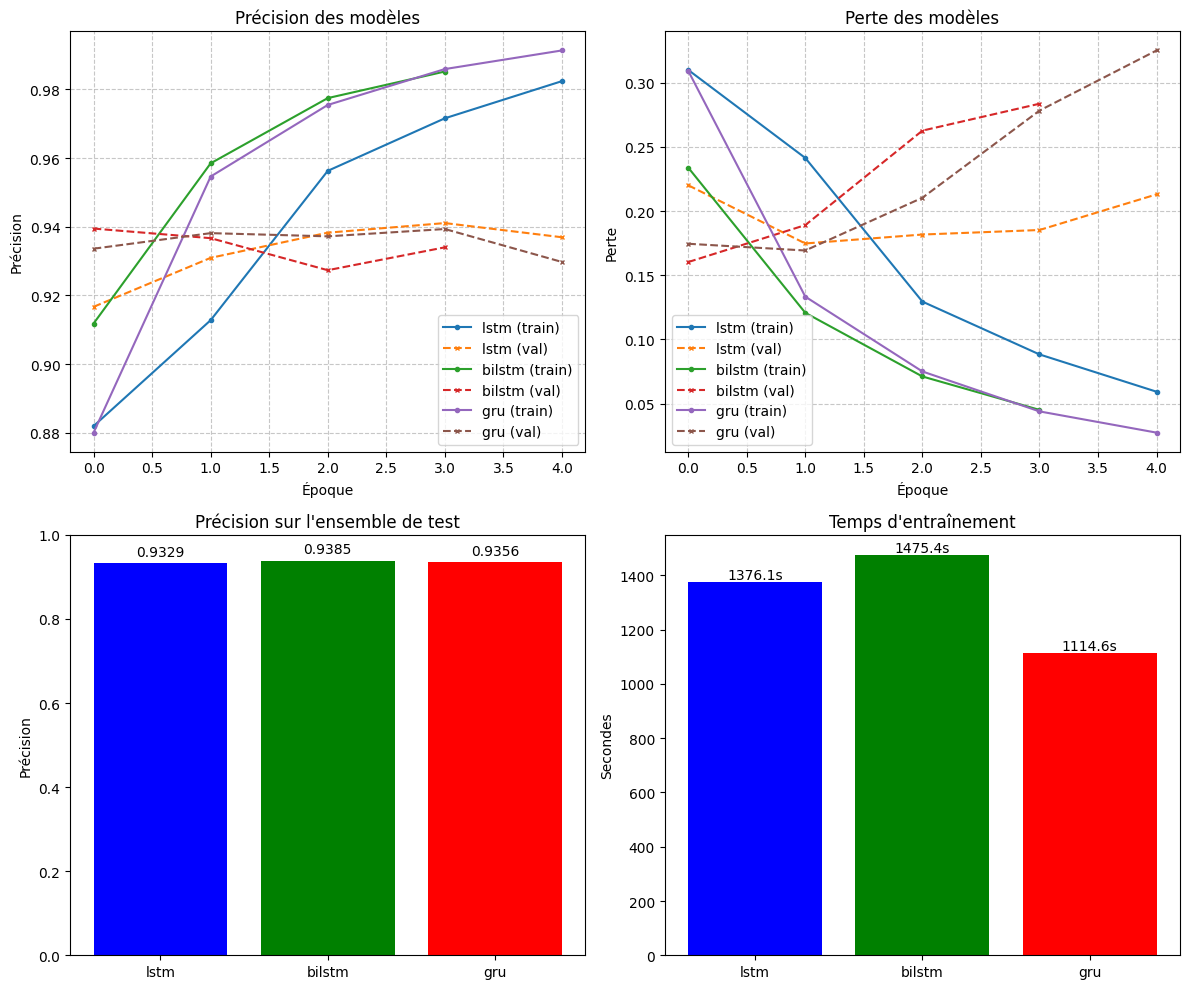


Visualisation des matrices de confusion...


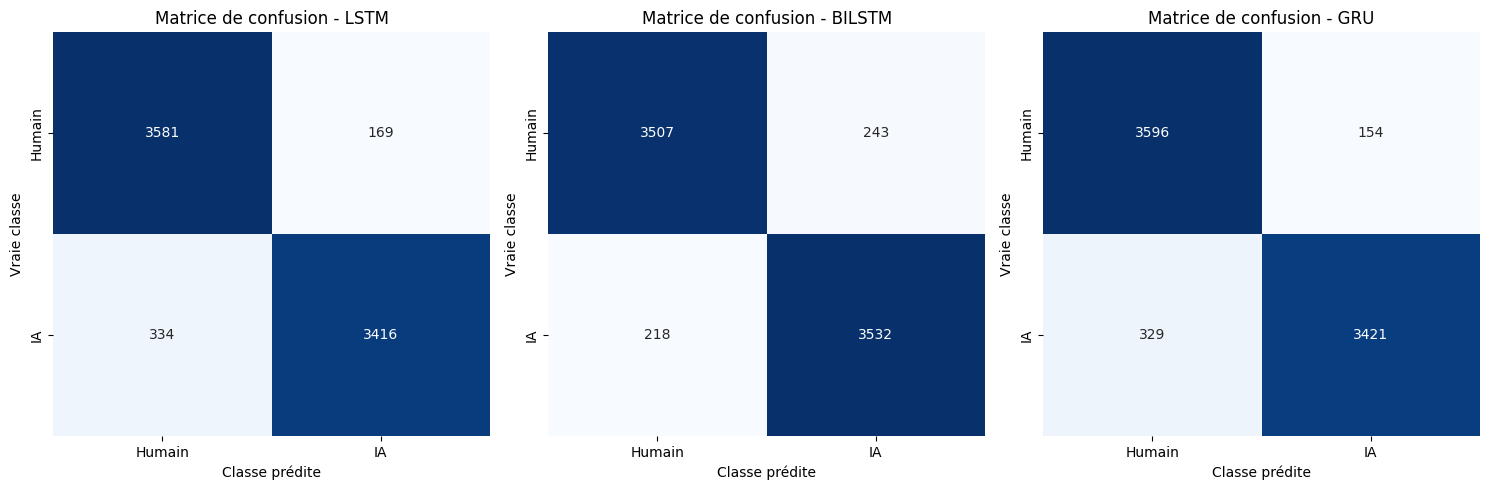


Visualisation des courbes ROC...


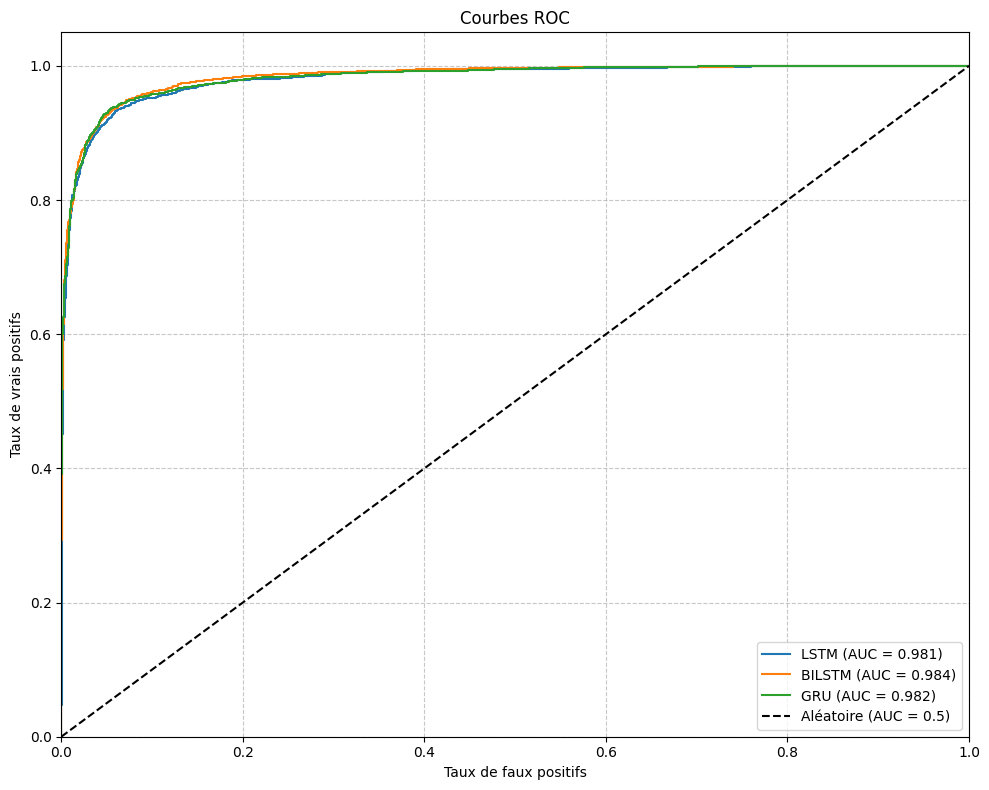


Comparaison des résultats:
   Modèle  Précision (validation)  Précision (test)  Perte (validation)  \
0    LSTM                0.930933          0.932933            0.174755   
1  BILSTM                0.939467          0.938533            0.160275   
2     GRU                0.938133          0.935600            0.169280   

   Perte (test)  Temps d'entraînement (s)  
0      0.179154               1376.057345  
1      0.161419               1475.442544  
2      0.178357               1114.624525  

Meilleur modèle basé sur la précision du test: BILSTM

Recommandation:
Pour une précision maximale: utilisez BILSTM
Pour un entraînement plus rapide: utilisez GRU


In [5]:
if __name__ == "__main__":

    data_path = r"C:\Documents\python_programms\Paraphrase_project\text_data_50k.csv"
    
    pipeline = TextClassificationPipeline(data_path)
    pipeline.run_full_pipeline()

In [ ]:
import os
from tensorflow.keras.models import load_model

def predict_text_voting(text, model_dir, tokenizer):
    models = []

    for file in os.listdir(model_dir):
        if file.endswith(".h5"):
            model_path = os.path.join(model_dir, file)
            print(f"Chargement du modèle : {model_path}")
            model = load_model(model_path)
            models.append(model)

    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=MAX_LENGTH, padding='post', truncating='post')

    predictions = []
    for model in models:
        prob = model.predict(padded, verbose=0)[0][0]
        label = 1 if prob > 0.5 else 0  # 1 = IA, 0 = Humain
        predictions.append(label)

    # Vote majoritaire
    final_label = "IA" if sum(predictions) >= len(predictions) / 2 else "Humain"
    confidence = sum(predictions) / len(predictions) if final_label == "IA" else 1 - (sum(predictions) / len(predictions))

    print(f"\nTexte: {text}")
    print(f"Prédiction finale: {final_label} (confiance: {confidence:.2%})")
 

In [7]:
sample_text = "Why did the scarecrow win an award? Because he was outstanding in his field!"
model_directory = r"C:\Documents\python_programms\Paraphrase_project\classic_algo_sauvegardes"
predict_text_voting(sample_text, model_directory, pipeline.tokenizer)

Chargement du modèle : C:\Documents\python_programms\Paraphrase_project\classic_algo_sauvegardes\model_detection_bilstm.h5


Chargement du modèle : C:\Documents\python_programms\Paraphrase_project\classic_algo_sauvegardes\model_detection_gru.h5


Chargement du modèle : C:\Documents\python_programms\Paraphrase_project\classic_algo_sauvegardes\model_detection_lstm.h5



Texte: Why did the scarecrow win an award? Because he was outstanding in his field!
Prédiction finale: IA (confiance: 100.00%)
